# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

## 데이터 읽기

특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 불러오기
현재 한 시편의 이미지 파일마다 id만 다른 동일한 내용의 json 파일 존재. 각 시편의 첫번째 json 파일 사용


In [1]:
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np

#import env
DATA_DIR_ROOT = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비') #

In [2]:
data_dir = os.path.join(DATA_DIR_ROOT, '3.sus_0_2circle_process', 'CENTER')

data_dir

'/home/mygenie/data/AI_DB_CYAUTOTECH/300장비/3.sus_0_2circle_process/CENTER'

In [3]:
!dir "$data_dir/JSON"

0  1  10  11  12  13  14  15  2  3  4  5  6  7	8  9


In [4]:
%%time

data = {}
json_dir = os.path.join(data_dir, 'JSON')

for sample_id in os.listdir(json_dir):
#     print(sample_id)
    meta_info = None
    
    json_file = os.listdir(os.path.join(json_dir, sample_id))[0]
    
    with open(os.path.join(json_dir, sample_id, json_file), encoding='utf-8') as f:
        _info = json.load(f)

        if meta_info is None:
            meta_info = {k:set() for k in _info.keys()}

        for k, v in _info.items():
            if k != 'input 식별자 ':
                meta_info[k].add(v)
                    
    data[int(sample_id)] = meta_info

CPU times: user 106 ms, sys: 503 ms, total: 609 ms
Wall time: 2.22 s


In [5]:
data[13]

{'input 식별자 ': set(),
 '소재 ': {' SUS'},
 '소재 사이즈 ': {' 30㎛'},
 '장비종류 ': {' Vulcan 300'},
 '산소농도 ': {' 0.1'},
 '챔버온도 ': {' 20℃'},
 '적층두께 ': {' 40㎛'},
 '해칭간격 ': {' 0.1mm'},
 '적층방향 ': {' 0'},
 '레이어수 ': {' 375'},
 '데이터셋타입 ': {' 0'},
 '항복강도': {'350.53MPa'},
 '인장강도': {'476.05MPa'},
 '연신율': {'7.7%'},
 '밀도': {'7.90'},
 'laser_speed': {'264'},
 'laser_power': {'1300'}}

## 데이터 전처리

빈 칸 없애기, 단위 처리 등



In [6]:
import re
re_num = re.compile(r'([0-9\.]+)(.*)')

In [7]:
materials = ['SUS']
facilities = ['Vulcan 300']

data_list = []
for i in range(16):
    _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}
    
    __data = {}
    for k, v in _data.items():
        if k == '소재':
            __data[k] = materials.index(v)
        elif k == '장비종류':
            __data[k] = facilities.index(v)
        elif k == '적층방향' or k == '데이터셋타입':
            __data[k] = int(v)
        elif 'power' in k:
            __data['laser_speed'] = float(v)## power 와 speed 가 반대로 기록
        elif 'speed' in k:
            __data['laser_power'] = float(v) ## power 와 speed 가 반대로 기록
        else:
            val, unit = re_num.match(v).groups()
            k = k if len(unit) == 0 else f'{k}({unit})'
            __data[k] = float(val)
    
    data_list.append(__data)

In [8]:
df = pd.DataFrame(data_list)
df['laser_density'] = df['laser_power'] / df['laser_speed']

print(json_dir)
df

/home/mygenie/data/AI_DB_CYAUTOTECH/300장비/3.sus_0_2circle_process/CENTER/JSON


,소재,소재 사이즈(㎛),장비종류,산소농도,챔버온도(℃),적층두께(㎛),해칭간격(mm),적층방향,레이어수,데이터셋타입,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
0,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,482.97,618.90,34.6,7.81,312.0,700.0,0.445714
1,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,625.85,795.83,34.6,7.82,264.0,700.0,0.377143
2,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,768.91,935.89,36.5,7.82,360.0,700.0,0.514286
3,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,477.21,623.11,36.5,7.80,408.0,700.0,0.582857
4,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,492.49,624.57,36.5,7.82,264.0,900.0,0.293333
5,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,465.91,581.00,36.5,7.82,312.0,900.0,0.346667
6,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,468.00,594.82,36.5,7.87,360.0,900.0,0.400000
7,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,526.56,643.13,34.6,7.78,408.0,900.0,0.453333
8,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,394.81,486.54,15.4,7.80,264.0,1100.0,0.240000
9,0,30.0,0,0.1,20.0,40.0,0.1,0,375.0,0,456.75,614.74,34.6,7.83,312.0,1100.0,0.283636


# 데이터 분석

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['font.family'] = 'NanumGothic'

def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5)):
    
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x, _y))

## 전체 데이터 분석

In [10]:
_idx = [True] * 16

# _idx[0] = False
# _idx[6] = False
# _idx[7] = False

# _idx[12] = False

df_corr = df.loc[_idx, :].iloc[:, 10:].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.994308,0.767160,-0.167524,-1.576712e-03,-6.758122e-01,0.535273
인장강도(MPa),0.994308,1.000000,0.760658,-0.118254,-2.537927e-02,-6.607960e-01,0.512691
연신율(%),0.767160,0.760658,1.000000,-0.304977,2.010240e-01,-7.486759e-01,0.657204
밀도,-0.167524,-0.118254,-0.304977,1.000000,-4.372865e-01,3.123475e-02,-0.239650
laser_power,-0.001577,-0.025379,0.201024,-0.437287,1.000000e+00,-1.515825e-16,0.557257
laser_speed,-0.675812,-0.660796,-0.748676,0.031235,-1.515825e-16,1.000000e+00,-0.806439
laser_density,0.535273,0.512691,0.657204,-0.239650,5.572572e-01,-8.064392e-01,1.000000


### 공정변수 vs 기계적 특성치 분포

In [11]:
y_cols = df.columns[10:14].tolist()
df_plot = df.loc[_idx, :]

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.

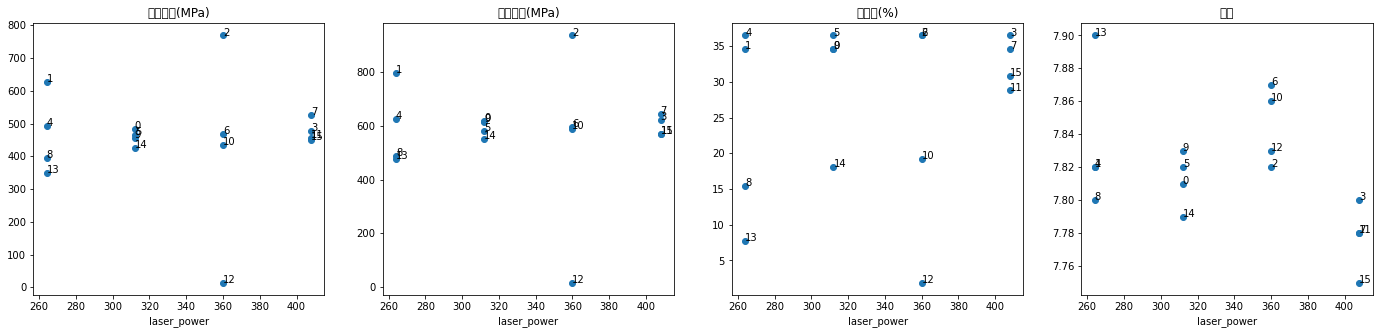

In [12]:
plot_annot(df_plot, 'laser_power', y_cols)

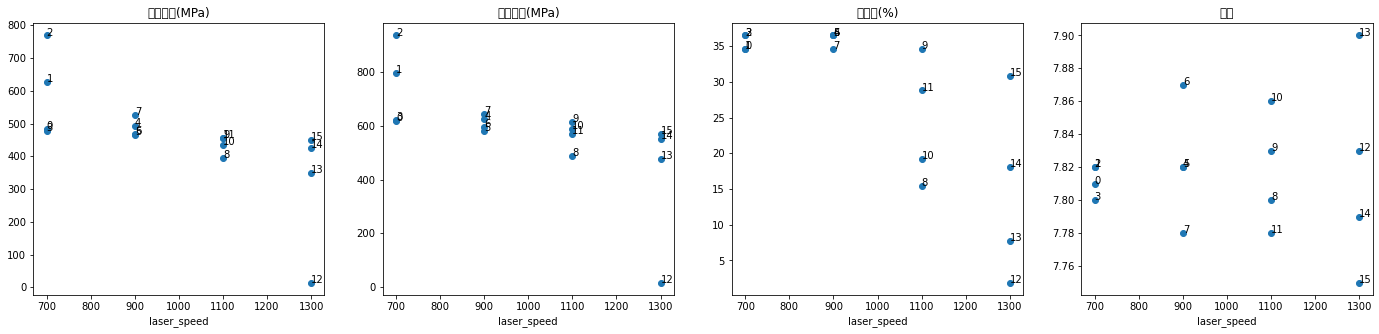

In [13]:
plot_annot(df_plot, 'laser_speed', y_cols)

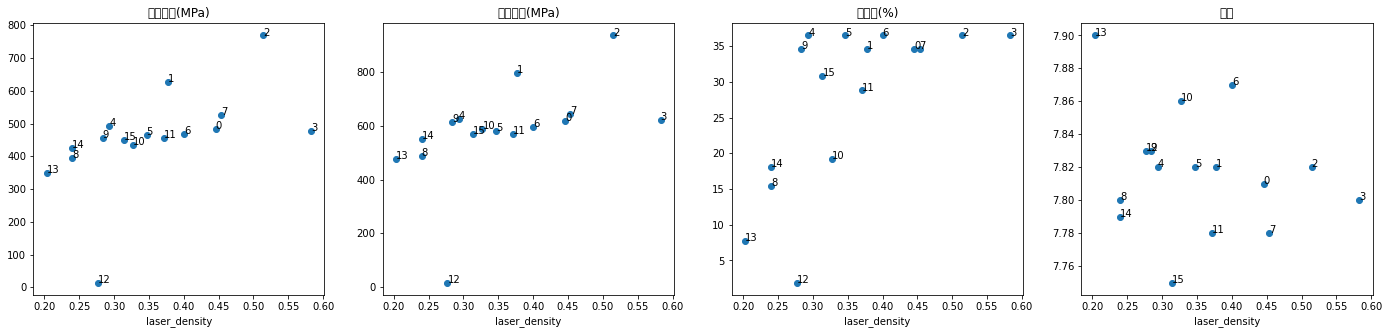

In [14]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

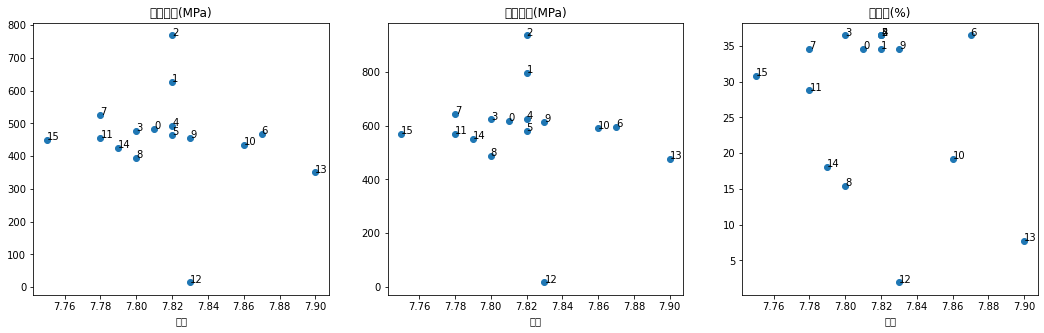

In [15]:
y_cols = df.columns[10:13].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))

## 이상치 제외 데이터 분석 (1, 2, 12 번 제외)

In [16]:
_idx = [True] * 16

_idx[1] = False
_idx[2] = False
_idx[12] = False

df_corr = df.loc[_idx, :].iloc[:, 10:].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.937090,0.896083,-0.447572,0.493736,-0.689127,0.700689
인장강도(MPa),0.937090,1.000000,0.861621,-0.261614,0.468340,-0.673429,0.697223
연신율(%),0.896083,0.861621,1.000000,-0.336528,0.410817,-0.706582,0.672455
밀도,-0.447572,-0.261614,-0.336528,1.000000,-0.478544,0.020898,-0.262043
laser_power,0.493736,0.468340,0.410817,-0.478544,1.000000,-0.153735,0.669137
laser_speed,-0.689127,-0.673429,-0.706582,0.020898,-0.153735,1.000000,-0.808584
laser_density,0.700689,0.697223,0.672455,-0.262043,0.669137,-0.808584,1.000000


### 공정변수 vs 기계적 특성치 분포

In [17]:
y_cols = df.columns[10:14].tolist()
df_plot = df.loc[_idx, :]

/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from curren

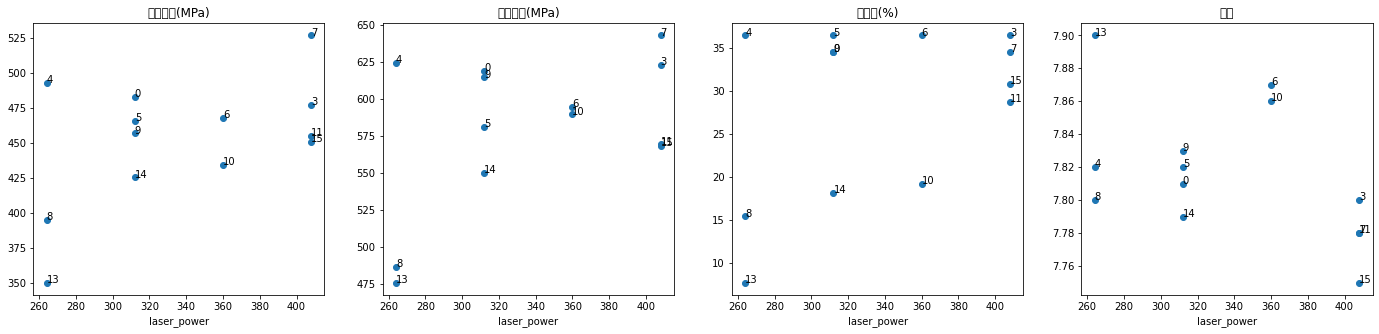

In [18]:
plot_annot(df_plot, 'laser_power', y_cols)

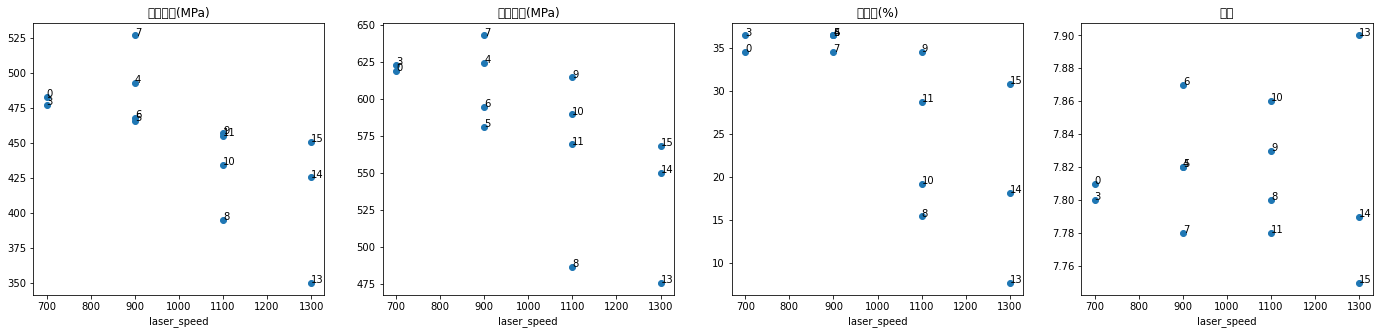

In [19]:
plot_annot(df_plot, 'laser_speed', y_cols)

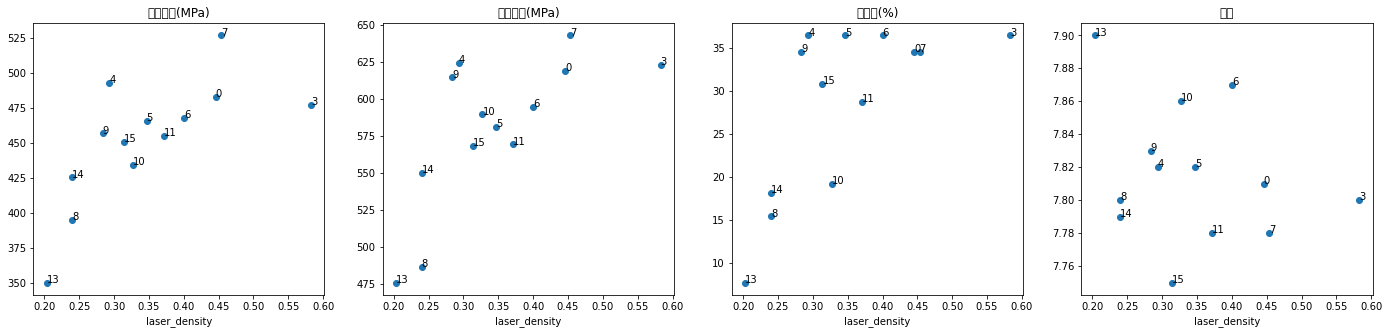

In [20]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

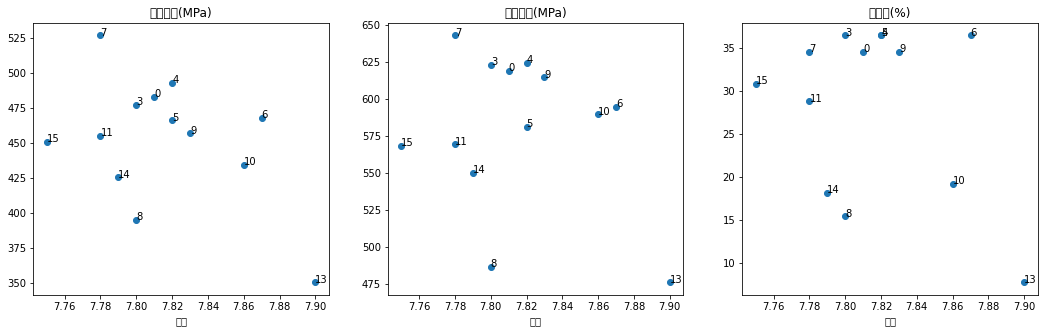

In [21]:
y_cols = df.columns[10:13].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))